In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchflow import Pipeline, B, C, D, F, V, W
from batchflow.models.torch import EncoderDecoder, UNet
from batchflow.models.torch.layers import ConvBlock
from batchflow.models.torch.layers.modules import ASPP
from batchflow.opensets import PascalSegmentation

In [3]:
dataset = PascalSegmentation(bar='n')

In [4]:
in_channels = 3
out_channels = 3

batch_size = 64
epoch_num = 5

IMAGE_SHAPE = (160, 160)

In [5]:
downsample_depth = 4
in_channels = 3
num_classes = 22
# https://github.com/tks10/segmentation_unet

model_config = {
    'inputs/images/shape': (in_channels, 160, 160), # can be commented
    'initial_block/inputs': 'images', # can be commented    

    'body/encoder': {
        'num_stages': downsample_depth,
        'order': ['skip', 'block', 'downsampling']
    },    
    'body/encoder/blocks': {
        'layout': 'cna cna',
        'filters': [in_channels*pow(2, i) for i in range(1, downsample_depth+1)]
    },
    'body/encoder/downsample': {
        'layout': 'p'
    },    
    
    'body/embedding': {
        'layout': 'cna cna', 
        'filters': [2*in_channels*pow(2, downsample_depth), in_channels*pow(2, downsample_depth)]
    },   

    'body/decoder': {
        'num_stages': downsample_depth,
        'order': ['upsampling', 'combine', 'block']
    },
    'body/decoder/upsample': {
        'layout': 'tna',
        'filters': [in_channels*pow(2, i-1) for i in range(downsample_depth, -1, -1)]
    },
    'body/decoder/combine': {
        'op': 'concat'
    },
    'body/decoder/blocks': {
        'layout': 'cna cna',
        'filters': [in_channels*pow(2, i-1) for i in range(downsample_depth, -1, -1)]
    },

    'head':{
        'layout': 'c',#a',
        'filters': num_classes,
        #'activation': 'softmax',
        'kernel_size': 1
    },
    
    'loss': 'ce',
    'optimizer': 'Adam'
}

In [6]:
model = EncoderDecoder(model_config)

In [7]:
model.short_repr()

Sequential(
  (body): Sequential(
    (encoder): EncoderModule(
      (skip-0): Identity()
      (block-0): ConvBlock
      DefaultBlock
        layout=cnacna
          Layer 0,  letter "c": (None, 3, 160, 160) -> (None, 6, 160, 160)
          Layer 1,  letter "n": (None, 6, 160, 160) -> (None, 6, 160, 160)
          Layer 2,  letter "a": (None, 6, 160, 160) -> (None, 6, 160, 160)
          Layer 3,  letter "c": (None, 6, 160, 160) -> (None, 6, 160, 160)
          Layer 4,  letter "n": (None, 6, 160, 160) -> (None, 6, 160, 160)
          Layer 5,  letter "a": (None, 6, 160, 160) -> (None, 6, 160, 160)
          
      (downsample-0): ConvBlock
      layout=p
        Layer 0,  letter "p": (None, 6, 160, 160) -> (None, 6, 80, 80)
        
      (skip-1): Identity()
      (block-1): ConvBlock
      DefaultBlock
        layout=cnacna
          Layer 0,  letter "c": (None, 6, 80, 80) -> (None, 12, 80, 80)
          Layer 1,  letter "n": (None, 12, 80, 80) -> (None, 12, 80, 80)
          Lay

In [8]:
def process_mask(x):
    """ Background label is 255 and must be transformed to 21
    to make labels sequential. """
    x = np.squeeze(x)
    np.place(x, x==255, 21)
    return x

train_pipeline = (dataset.train.p
    .init_variable('loss_history', [])
    .init_model('dynamic', EncoderDecoder, 'model', config=model_config)
    .resize(size=IMAGE_SHAPE, src=['images', 'labels'], dst=['images', 'labels'])
    .to_array(channels='first', src=['images', 'labels'], dst=['images', 'labels'])
    .process_mask(B('labels'), save_to=B('labels'))
    .train_model('model', B('images'), B('labels'),
                fetches='loss', save_to=V('loss_history', mode='a'), use_lock=True)
)

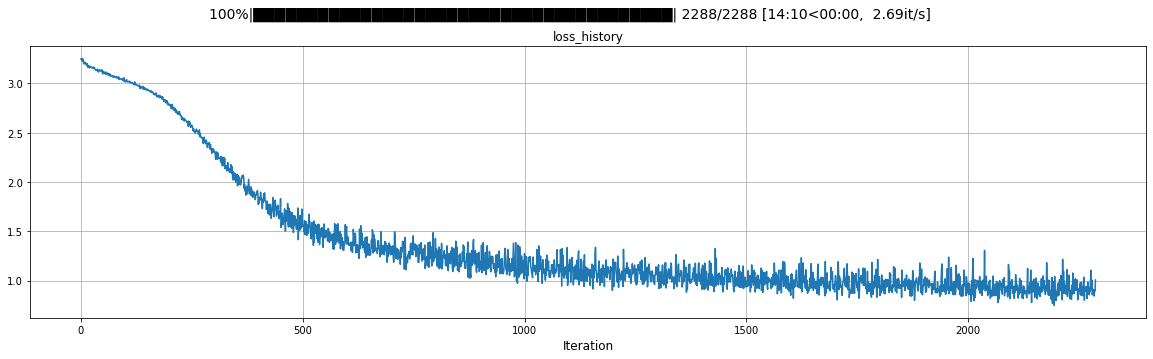

In [9]:
train_pipeline.run(64, n_epochs=100, shuffle=True,
                   bar={'bar': 'n', 'frequency': 10,
                        'graphs': 'loss_history'})

In [10]:
pipeline = (dataset.test.p
                .import_model('model', train_pipeline)
                .init_variable('metrics')
                .init_variable('predictions')
                .resize(size=IMAGE_SHAPE, src=['images', 'labels'], dst=['images', 'labels'])
                .to_array(channels='first', src=['images', 'labels'], dst=['images', 'labels'])
                .process_mask(B('labels'), save_to=B('labels'))                
                .predict_model('model', B('images'), fetches='predictions',
                               save_to=V('predictions'))
                .gather_metrics('classification', B('labels'), V('predictions'),
                                 axis=1, fmt='logits', num_classes=num_classes,
                                 save_to=V('metrics', mode='update'))
            )

In [11]:
pipeline.run(32, drop_last=False, bar='n')

  0%|                                                                                                         …

In [12]:
f1_scores = pipeline.v('metrics').evaluate('f1_score', agg='mean', multiclass=None)

/notebooks/sorokina/batchflow/batchflow/models/metrics/classify.py:343: RuntimeWarning: invalid value encountered in true_divide
  return 2 * (recall * precision) / (recall + precision)


In [13]:
f1_scores 

array([0.78689198, 0.9378882 , 0.94616977, 0.92891649, 0.95031056,
       0.93374741, 0.9489303 , 0.91235335, 0.9178744 , 0.91511387,
       0.95100069, 0.94824017, 0.91166322, 0.94547964, 0.94755003,
       0.09476372, 0.94133885, 0.96066253, 0.9378882 , 0.94202899,
       0.9489303 , 0.03968625])

In [14]:
batch = pipeline.next_batch(3)
outputs = pipeline.v('predictions')[:3]

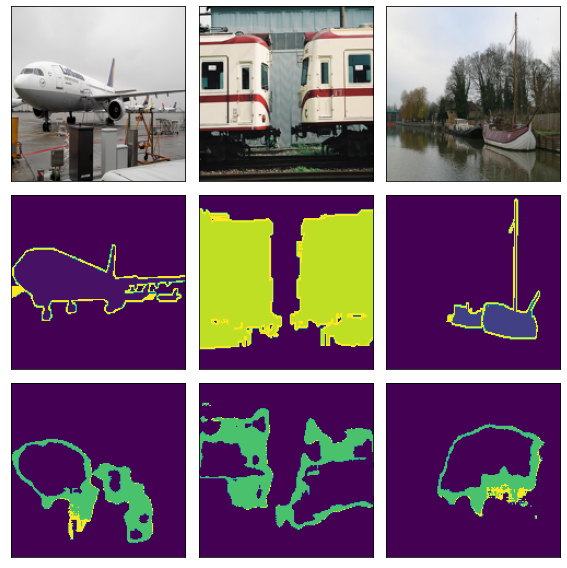

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(np.moveaxis(batch.images[picture_num] / 255, 0, -1))
    elif picture_num < 6:
        ax.imshow(batch.labels[picture_num-3])
    else:
        ax.imshow(np.argmax(outputs[picture_num-6], axis=0))


plt.tight_layout()
plt.show()